In [2]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import matplotlib.pyplot as plt 

import cv2
from PIL import Image

import SimpleITK as sitk
from torchio.transforms import Affine
from torchio import Image

from pathlib import Path

from bs4 import BeautifulSoup
import json

In [3]:
def read_crop_info(file_name):
    
    with open(file_name, "r") as fp:
        crop_info = json.load(fp)
        
    return crop_info

def read_rotation_info(file_name):
    
    with open(file_name, "r") as fp:
        rot = json.load(fp)
        
        
        #rotation_info = {'x_dir': {'x': x_dir.getX(), 'y': x_dir.getY(), 'z': z_dir.getZ()},
        #             'y_dir': {'x': y_dir.getX(), 'y': y_dir.getY(), 'z': y_dir.getZ()},
        #             'z_dir': {'x': z_dir.getX(), 'y': z_dir.getY(), 'z': z_dir.getZ()}
        #            }
        
    x = [rot['x_dir']['x'], rot['x_dir']['y'], rot['x_dir']['z']]
    y = [rot['y_dir']['x'], rot['y_dir']['y'], rot['y_dir']['z']]
    z = [rot['z_dir']['x'], rot['z_dir']['y'], rot['z_dir']['z']]
    
  
    return x,y,z
    

def read_dragonfly_transform(file_name):
    
    with open(str(file_name), 'r') as f:
        data = f.read()

#print(data[12:])

    xml_data = BeautifulSoup(data[12:], "xml")

    #print(xml_data)

    x_dir = xml_data.find('direction0')
    y_dir = xml_data.find('direction1')
    z_dir = xml_data.find('direction2')

    x2 = [float(x_dir.get('x')), float(x_dir.get('y')), float(x_dir.get('z'))]
    y2 = [float(y_dir.get('x')), float(y_dir.get('y')), float(y_dir.get('z'))]
    z2 = [float(z_dir.get('x')), float(z_dir.get('y')), float(z_dir.get('z'))]
    
    f.close()
    
    return x2,y2,z2


def save_np_as_multitiff_stack(volume, file_name):
    
    imlist = []
    for i in range(volume.shape[0]):
        imlist.append(Image.fromarray(volume[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist 
    

## Testing

In [5]:
x = [1, 0, 0]
y = [0, 1, 0]
z = [0, 0, 1]



r1 = R.from_euler('xyz', [0, 45, 0], degrees=True)

x2 = r1.apply(x)
print(x2)

y2 = r1.apply(y)
print(y2)

z2 = r1.apply(z)
print(z2)

[ 0.70710678  0.         -0.70710678]
[0. 1. 0.]
[0.70710678 0.         0.70710678]


In [6]:
x2 = [0.70805369178113231, 3.7762687912420295e-17, -0.70615860085048132]
y2 = [0, 1, 0]
z2 = [0.70615860085048132, -2.9216395384872545e-17, 0.7080536917811322]

[-33.47867137  13.25431229  39.66602721]


In [21]:
#path = Path("c:\\Users\\fe0968\\Documents\\data\\medaka\\")
path = Path("c:\\Users\\fe0968\\Documents\\data\\medaka\\landmarks\\data_for_workshop\\scaled\\")

dataset = '807'
sitk_image = sitk.ReadImage(path / f'{dataset}.tif')


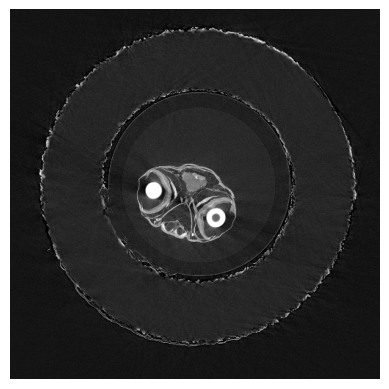

In [22]:
plt.imshow(sitk.GetArrayViewFromImage(sitk_image)[1380], cmap= 'gray')
plt.axis('off');

## Rotate

In [23]:
#rotation_radians = np.radians(rotation_degrees).tolist()
rotation_degrees = [0,0,30]

x = [1, 0, 0]
y = [0, 1, 0]
z = [0, 0, 1]

#x2,y2,z2 = read_dragonfly_transform(path / 'transform.ORSObject')

#x2,y2,z2 = read_rotation_info(path / f'{dataset}_rot_info.txt')
#res_rot = R.align_vectors([z2,y2,x2], [z,y,x])
#rotation_degrees = res_rot[0].as_euler('zyx', degrees=True)
print(rotation_degrees)

#degrees = -rotation_degrees
degrees = rotation_degrees
#degrees[1] = -degrees[1] 

#print(degrees)

if True:

    img_rotation = Affine(scales=[1.0, 1.0, 1.0], degrees=degrees, translation=[0,0,0],
                                  center='image')

    #pos_rotation = sitk.Euler3DTransform()
    #pos_rotation.SetRotation(*rotation_radians)

    image_data = sitk.GetArrayFromImage(sitk_image).astype('uint8')
    #image_data = sitk.GetArrayFromImage(sitk_im<age).transpose(2, 1, 0).astype('uint8')
    print('Image shape', image_data.shape)
    
    #offset_z = 450
    #image_data = image_data[offset_z:,:,:]

    image_rotated = img_rotation(np.expand_dims(image_data, axis=0))[0]
    print('Image shape', image_rotated.shape)
    print(image_rotated.dtype)

    #result_image = sitk.GetImageFromArray(image_rotated.transpose(2, 1, 0))
    print('Done!')

[0, 0, 30]
Image shape (1530, 504, 504)
Image shape (1530, 504, 504)
float32
Done!


In [63]:
## [-21.55693671  10.2328246   17.03000717]

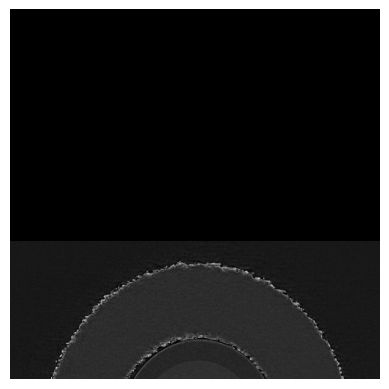

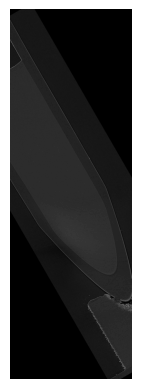

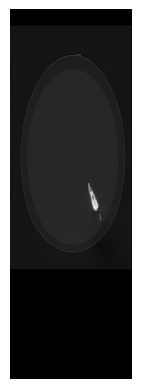

In [25]:
plt.imshow(image_rotated[1380], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(image_rotated[:,:,400], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(image_rotated[:,140,:], cmap='gray')
plt.axis('off')
plt.show()

## Crop

In [49]:
cr = read_crop_info(path / f'{dataset}_crop_info.txt')
image_crop = image_rotated[cr['z']:cr['z']+cr['d'], cr['y']:cr['y']+cr['h'], cr['x']:cr['x']+cr['w']]

In [50]:
%%time
save_np_as_multitiff_stack(image_crop.astype('uint8'), f'test_rotated_crop.tif')

Wall time: 5.51 s


In [17]:
%%time
save_np_as_multitiff_stack(image_rotated.astype('uint8'), f'test_rotated.tif')

AttributeError: type object 'Image' has no attribute 'fromarray'

In [45]:
%%time
sitk_image = sitk.GetImageFromArray(image_rotated.astype('uint8'))
sitk.WriteImage(sitk_image, f'test_rotated.tif')

Wall time: 23.4 s


In [220]:
# open file in write mode
with open('info.txt', 'w') as fp:
    for item in degrees:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


## Dragonfly script 

In [225]:
from OrsHelpers.viewLogger import ViewLogger
from OrsPlugins.orsimageloader import OrsImageLoader
from OrsHelpers.managedhelper import ManagedHelper
from OrsHelpers.datasethelper import DatasetHelper
from OrsHelpers.layoutpropertieshelper import LayoutPropertiesHelper
from OrsPythonPlugins.OrsObjectPropertiesList.OrsObjectPropertiesList import OrsObjectPropertiesList
from OrsPythonPlugins.OrsDerivedDataset.OrsDerivedDataset import OrsDerivedDataset
from OrsHelpers.roihelper import ROIHelper
from OrsHelpers.structuredGridLogger import StructuredGridLogger
from OrsHelpers.structuredGridHelper import StructuredGridHelper
from OrsHelpers.reporthelper import ReportHelper
from PIL import Image
import math

#--------------------------------------------------------------
# Global settings
#--------------------------------------------------------------
PATH_INPUT_FOLDER = 'c:/Users/fe0968/Documents/data/medaka/landmarks/data_for_workshop/scaled/'
PATH_OUTPUT_INFO_FOLDER = 'c:/Users/fe0968/Documents/data/medaka/landmarks/data_for_workshop/scaled/'

dataset_list = ['800', '801', '803', '804', '805', '807', '809', '1075']

#SPACING = 1.23e-06 # Pixel size in micrometers
SPACING = 0.001 # Pixel size in micrometers

current_dataset = 'no'
current_index = 0

def read_dataset_list():
    print(f'Datasets')
    return

def load_next_dataset():
    
    global current_index
    global current_dataset
    
    current_dataset = dataset_list[current_index]
    vol = load_volume(current_dataset + '.tif')
    
    current_index = current_index+1
    
    return vol

def load_next_dataset_and_copy():
    
    vol = load_next_dataset()
    rot = make_copy(vol)
    
    return vol, rot

def get_volume_size(volume_path):

    im = Image.open(volume_path)
    return (im.size[0], im.size[1], im.n_frames)

def load_volume(volume_file_name = 'fA2p0_17_2_s_eig16_new_sagittal.tif'):

    fileNamesListElement = PATH_INPUT_FOLDER + volume_file_name
    fileNames = [fileNamesListElement]

    vol_size = get_volume_size(PATH_INPUT_FOLDER + volume_file_name)

    #xSize = 1048
    #ySize = 1140
    #zSize = 1116

    xSize = vol_size[0]
    ySize = vol_size[1]
    zSize = vol_size[2]
    tSize = 1
    minX = 0
    maxX = xSize -1
    minY = 0
    maxY = ySize -1
    minZ = 0
    maxZ = zSize -1
    xSampling = 1
    ySampling = 1
    zSampling = 1
    tSampling = 1
    xSpacing = SPACING
    ySpacing = SPACING
    zSpacing = SPACING
    slope = 1.0
    offset = 0.0
    dataUnit = ''
    invertX = False
    invertY = False
    invertZ = False
    axesTransformation = 0
    datasetName = volume_file_name
    convertFrom32To16bits = False
    dataRangeMin = 0.0
    dataRangeMax = 0.0
    frameCount = 1

    additionalInfo = 'PD94bWwgdmVyc2lvbj0iMS4wIj8+CjxJbWFnZUxvYWRlck1vZGVsIElzRGF0YVJHQj0iZmFsc2UiIFJHQk91dHB1dD0iMCIgSW52ZXJ0SW50ZW5zaXR5PSJmYWxzZSIgLz4K'


    output = OrsImageLoader.createDatasetFromFiles(fileNames=fileNames,
                                                xSize=xSize,
                                                ySize=ySize,
                                                zSize=zSize,
                                                tSize=tSize,
                                                minX=minX,
                                                maxX=maxX,
                                                minY=minY,
                                                maxY=maxY,
                                                minZ=minZ,
                                                maxZ=maxZ,
                                                xSampling=xSampling,
                                                ySampling=ySampling,
                                                zSampling=zSampling,
                                                tSampling=tSampling,
                                                xSpacing=xSpacing,
                                                ySpacing=ySpacing,
                                                zSpacing=zSpacing,
                                                slope=slope,
                                                offset=offset,
                                                dataUnit=dataUnit,
                                                invertX=invertX,
                                                invertY=invertY,
                                                invertZ=invertZ,
                                                axesTransformation=axesTransformation,
                                                datasetName=datasetName,
                                                convertFrom32To16bits=convertFrom32To16bits,
                                                dataRangeMin=dataRangeMin,
                                                dataRangeMax=dataRangeMax,
                                                frameCount=frameCount,
                                                additionalInfo=additionalInfo)

    volume_channel = output[0]
    ManagedHelper.publish(anObject=volume_channel)

    name = 'toplayout\\scene_0'
    isVisible = True
    
    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                    dataset=volume_channel,
                                                    isVisible=isVisible)

  

    layoutFullName = 'toplayout\\scene_0'
    lutUUID = '7b00da82eefc11e68693448a5b87686a'
    aScalarValueTypeTag = ''
 
    LayoutPropertiesHelper.set3DLUTUUIDFromGenealogicalName(layoutFullName=layoutFullName,
                                                            anObject=volume_channel,
                                                            lutUUID=lutUUID,
                                                            aScalarValueTypeTag=aScalarValueTypeTag)


    return volume_channel

def make_copy(dataset):
    
    d = DatasetHelper.copyDataset(aDataset=dataset)
    
    d.setTitle(newVal='aligned', logging=True)
    
    d.publish(logging=True)
    
    name = 'toplayout\\scene_0'

    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                       dataset=d,
                                                       isVisible=True)
    return d

def resample(orig_dataset, resampled_dataset):
    newTitle_3 = 'aligned (Resampled)'


    derivedDataset = OrsDerivedDataset.copyStructuredGridIntoAnotherShape(sourceStructuredGrid=resampled_dataset,
                                                                         referenceStructureGrid=orig_dataset,
                                                                         newTitle=newTitle_3)
    
    derivedDataset.publish(logging=True)
    
    name = 'toplayout\\scene_0'

    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                       dataset=derivedDataset,
                                                       isVisible=True)
    
    return derivedDataset

def save_crop_box_info(im, file_name='crop'):
    v,d = StructuredGridHelper.getClipBoxForCurrentView(im)
    b = v.getBox(0)
    
    crop_info = {'x': math.floor(b.getOrigin().getX() / SPACING  + 1),
                'y': math.floor(b.getOrigin().getY() / SPACING + 1),
                'z': math.floor(b.getOrigin().getZ() / SPACING + 1),
                'w': math.floor(b.getDirection0Size() / SPACING + 0.5),
                'h': math.floor(b.getDirection1Size() / SPACING + 0.5),
                'd': math.floor(b.getDirection2Size() / SPACING + 0.5)
                    }
    
    with open(PATH_OUTPUT_INFO_FOLDER + file_name + '_crop_info.txt', "w") as fp:
        json.dump(crop_info, fp)  # encode dict into JSON
        
    print(f'Dataset: {file_name}: Croppping info is saved')
    
    
def save_rotation_info(im, file_name='rot'):
    b = im.getBox()
    
    x_dir = b.getDirection0()
    y_dir = b.getDirection1()
    z_dir = b.getDirection2()
    
    rotation_info = {'x_dir': {'x': x_dir.getX(), 'y': x_dir.getY(), 'z': x_dir.getZ()},
                     'y_dir': {'x': y_dir.getX(), 'y': y_dir.getY(), 'z': y_dir.getZ()},
                     'z_dir': {'x': z_dir.getX(), 'y': z_dir.getY(), 'z': z_dir.getZ()}
                    }
    
    with open(PATH_OUTPUT_INFO_FOLDER + file_name + '_rot_info.txt', "w") as fp:
        json.dump(rotation_info, fp)  # encode dict into JSON 
        
    print(f'Dataset: {file_name}: Rotation info is saved')
        
def clean(vol):
    DatasetHelper.deleteDataset(aDataset=vol)
    
def clean_all():
    global vol
    global rot
    global res
    
    DatasetHelper.deleteDataset(aDataset=vol)
    DatasetHelper.deleteDataset(aDataset=rot)  
    DatasetHelper.deleteDataset(aDataset=res)  
    
def save_all_info():
    global vol
    save_rotation_info(rot, current_dataset)
    save_crop_box_info(res, current_dataset)
    

## Steps

In [222]:
vol = load_next_dataset()
#vol = load_volume('800.tif')
rot = make_copy(vol)


vol, rot = load_next_dataset_and_copy()

## Manually align the rotation

save_rotation_info(rot, '807)

res = resample(vol, rot)

## Manually align the cropping box

save_crop_box_info(res, '807')

In [ ]:
vol, rot = load_next_dataset_and_copy()
res = resample(vol, rot)
clean_all()

In [ ]:
b = im.getBox()
x = b.getDirection0().getX()
print(x)

In [9]:
path = Path("c:\\Users\\fe0968\\Documents\\data\\medaka\\landmarks\\data_for_workshop\\scaled\\")

In [14]:
read_rotation_info(path / '807_rot_info.txt')

([0.9112168911367365, -0.33506703082140044, 0.9480826063631126],
 [0.3854578165965902, 0.8987195125713549, 0.2091064545825776],
 [0.14527921025284518, -0.2829016128975527, 0.9480826063631126])

In [42]:
import time

In [41]:
%%time
c = 1

Wall time: 1 ms


In [43]:
%%time
time.sleep(2.4)

Wall time: 2.4 s


In [1]:
from Geometry3D import *

In [ ]:
l1 = Line(Point(1,2,1), Point(5,6,1))
l2 = Line(Point(2,6,1), Point(5,4,1))

s1 = Segment(Point(1,2,0), Point(5,6,0))
s2 = Segment(Point(2,6,0), Point(5,4,0))

#inter = intersection(l2, l2)
intersection(s1,s2)

